In [1633]:
%pylab inline

import matplotlib.dates as md
from random import randint as rnd

rcParams['figure.figsize'] = (10,8)
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 0.8
    
xfmt = md.DateFormatter('%H:%M:%S')

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


Delta:  0.003 Avg volatility for which this delta is opt: 0.20384417436666666
Delta:  0.005 Avg volatility for which this delta is opt: 0.1519114393939394
Delta:  0.01 Avg volatility for which this delta is opt: 0.12254123975409838
Delta:  0.015 Avg volatility for which this delta is opt: 0.09209352564102564
Delta:  0.02 Avg volatility for which this delta is opt: 0.12381035714285714
Delta:  0.025 Avg volatility for which this delta is opt: 0.242816
Delta:  0.03 Avg volatility for which this delta is opt: nan


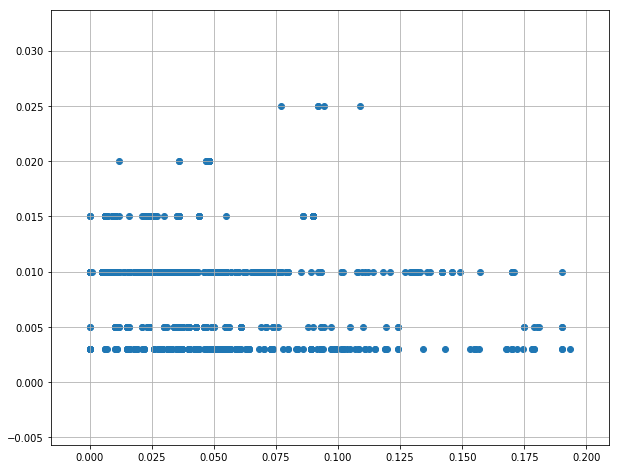

In [1684]:
y = [0.003, 0.005, 0.010, 0.015, 0.02, 0.025, 0.03]
files = ["model2_pnl_003.out", "model2_pnl_005.out", "model2_pnl_010.out", "model2_pnl_015.out", "model2_pnl_020.out", "model2_pnl_025.out", "model2_pnl_030.out"]
sz = 1000
data = []
for i in range(len(y)):
    data.append(readData(files[i], labels))
ans = [[] for _ in range(len(y))]
def opt(l, r):
    if (data[0]["volt"][l:r]).max() / (data[0]["volt"][l:r]).mean() > 5:
        return [-1, -1]
    opty = 0
    optp = -10 ** 9
    for i in range(len(files) - 1):
        profit = data[i]["pnl"][l] - data[i]["pnl"][r]
        if profit > optp:
            optp = profit
            opty = i
    ans[opty].append((data[i]["volt"][l:r]).sum())
    return [(data[i]["volt"][l])* 100, y[opty]]
X, Y = [], []
for i in range(1000):
    l = rnd(0, 34000)
    a, b = opt(l, l + 300)
    if a != -1:
        X.append(a)
        Y.append(b)
plt.scatter(X, Y)
for i in range(len(ans)):
    print("Delta: ",y[i], "Avg volatility for which this delta is opt:", sum(ans[i]) / len(ans[i]))

# Model 2
При предположении, что $alpha$ доля информированных трейдеров, а также, что информированные трейдеры покупают/продают тогда и только тогда, когда цена покупки/продажи выше/ниже настоящей цены, о которой они знают, и которая с наибольшей вероятностей наступит через некоторое время на даннный момент, а остальные торгуют случайно, можно выразить $\rho_{ask} = E[Price|p > Price_{ask}]$, $\rho_{bid}$ аналогично путем не самых сложных математических преобразований, где $p$ -- оценка цены иным игроком, иными словами матожидание цены в случае покупки/продажи, равно цене ордера, если поддерживать вероятности каждой цены быть настоящей справдливой ценой. Они поддерживаются тем, что от каждого трейда вероятности цен выше/ниже цены исполнения увеличиваются, а другие уменьшаеются (домножаются на константу). 

Из этих цен вычитается значение выпуклой вниз функции от fq, перегиб который начинается при приблежении точки максимального объема портфеля, это позволяет осуществлять контроль портфеля. И выставляются ордера, если цена не захлестывает цены в ордербуке.

К цене прибаляется некий сигминд от среднего модуля колебания цены за некоторый посдений промежуток времени.

Если $\rho_{ask}, \rho_{bid}$ сильно отличаются от настоящей цены, то все ордеры отменяются, берется отдых на короткое время, портфель обнуляется, т. к. сильное отклоние этих показателей говорит о токсичности трейдов, что может произойти скачок. Также все обнуляется, если происходит резкий скачок.

In [1725]:
def readData(file, label, l = 0, r = -1):
    fin = open(file, "r")

    data = dict()
    for i in label:
        data[i] = []

    for i in fin.readlines()[l:r]:
        arr = [float(x) for x in i.split()]
        if len(label) != len(arr):
            raise BaseException
        for i in range(len(label)):
            data[label[i]].append(arr[i])

    for i in label:
        data[i] = np.array(data[i])
    return data

In [1737]:
labels = ["ask", "bid", "est", "bid_p", "std", "ask_p", "pnl", "fq", "volt", "fq2", "total", "ask_l", "bid_l", "delt"]
model2_data = readData("model2.out", labels)

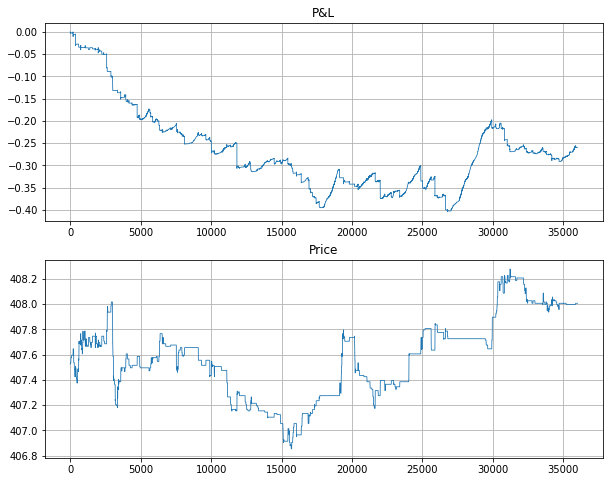

In [1787]:
plot1 = subplot2grid((2,1),(0,0))
plot1.set_title("P&L")
plot1.plot(model2_data["pnl"])

plot2 = subplot2grid((2,1),(1,0))
plot2.set_title("Price")
plot2.plot((model2_data["ask"] + model2_data["bid"]) / 2)

Max fq:  144.28040649149997 USD


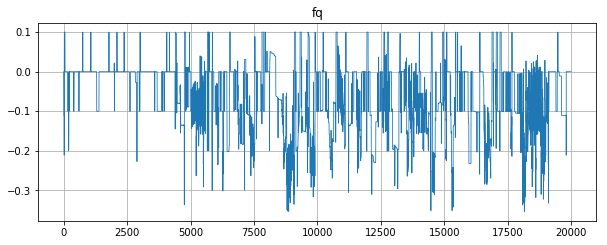

In [1729]:
print("Max fq: ", max(abs(model2_data["fq"])) * est.mean(), "USD")

plot = subplot2grid((2,1),(0,0))
plot.set_title("fq")
plot.plot(model2_data["fq"])

plot2 = subplot2grid((2,1),(1,0))
plot2.plot(model2_data["delt"])
plot2.set_title("Additional delta for volatility")

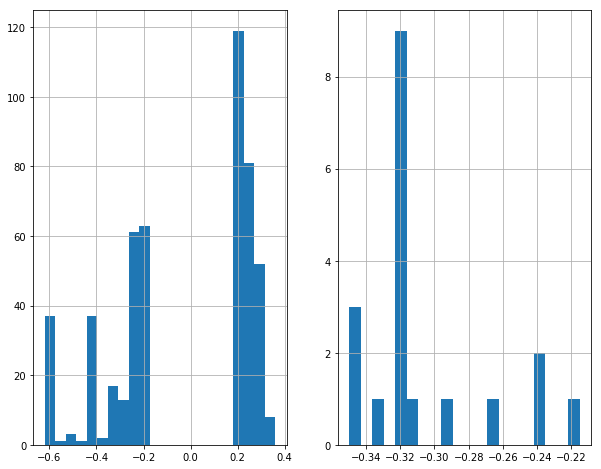

In [1724]:
fig, axs = plt.subplots(1, 2)
price = (model2_data["ask"] + model2_data["bid"]) / 2
dt = 100
dprice1 = np.array(list(price)[dt:]) - np.array(list(price)[:-dt])
dt = 20
dprice2 = np.array(list(price)[dt:]) - np.array(list(price)[:-dt])

dprice1 = dprice1[abs(dprice1) > 0.2]
dprice2 = dprice2[abs(dprice2) > 0.2]

_ = axs[0].hist(dprice1, bins=22)
_ = axs[1].hist(dprice2, bins=20)


Есть некоторая тенденция, что резкие скачки чаще идут в отрицательную сторону

# Model 3

Модель выставляет оредера со всех сторон на бесконечную (меньше величины колебания цены) глубину. Нетрудно показать, что если цена будет меняться не больше, чем на один пункт за раз, то есть при изменении цены получится успеть выставить оредера, то прибыль будет $(\sum |price_i - price_{i - 1}|) - (price_T - price_0)^2$.

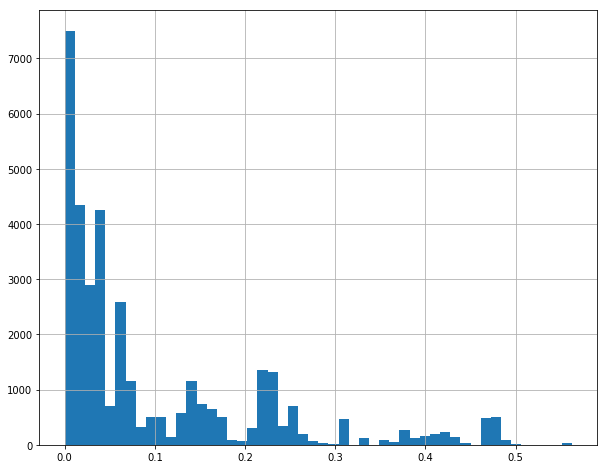

In [1744]:
_ = hist((price - price[0]) ** 2, bins=50)

Max fq:  309.75454501 USD


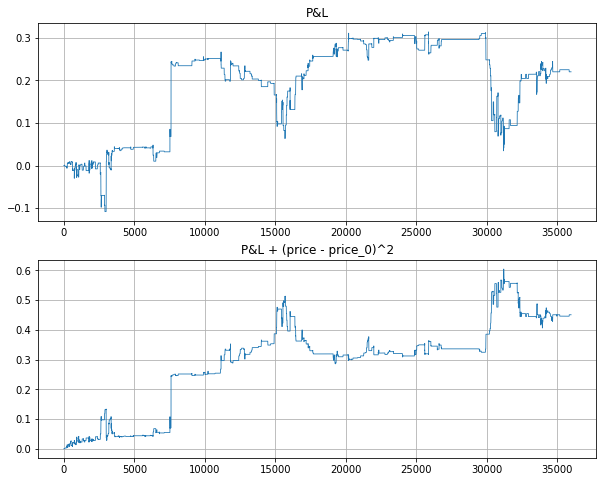

In [1783]:
model3_data = readData("model3.out", ["ask", "bid", "order_cnt", "pnl", "fq", "sign", "fq2", "abs"])

ax = []
ax.append(subplot2grid((2,1),(0,0)))
ax.append(subplot2grid((2,1),(1,0)))

print("Max fq: ", max(abs(model3_data["fq"])) * est.mean(), "USD")

ax[1].set_title("P&L + (price - price_0)^2")
ax[1].plot(model3_data["pnl"] + (price - price[0])**2)
delt = price - price[0] 
ax[0].set_title("P&L")
ax[0].plot(model3_data["pnl"])

По идеи нижний график должен стабильно расти, однако из-за скачков, как мы видим, бывают проблемы